# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT TP. HCM
## KHOA CÔNG NGHỆ THÔNG TIN
### BỘ MÔN KỸ THUẬT DỮ LIỆU
<br/>

# Đề tài:
# ỨNG DỤNG PHƯƠNG PHÁP THỐNG KÊ VÀ HỌC MÁY DỰ ĐOÁN GIÁ NÔNG SẢN

<br/>

<p>Họ và tên Sinh viên 1 : Huỳnh Hạo Nhị MSSV 1: 20133006 <p>
<br/>
Họ và tên Sinh viên 2 : Võ Hoài Thương MSSV 2: 20133012

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV

from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# Dữ liệu

In [2]:
RICE_QUANTITY_URI = "https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/CaPhe/gia_cafe_xang_den_2023.csv"

In [3]:
var_file_name = 'var_gia_cafe_xang.joblib'
varma_file_name = 'var_gia_cafe_xang.joblib'


## VAR MODEL

Mô hình VAR (vector autoregressive models) được sử dụng cho chuỗi thời gian đa biến. Cấu trúc của nó là mỗi biến là một hàm tuyến tính của các lag của chính nó và các lag của các biến khác

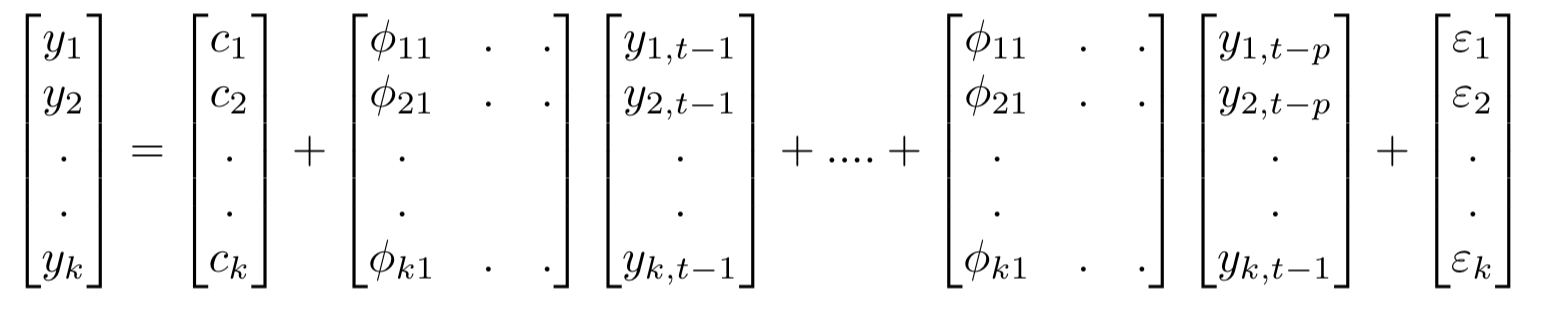

In [4]:
df = pd.read_csv(RICE_QUANTITY_URI)

In [5]:
df.set_index('date', inplace=True)

In [6]:
df.head()

,price,RON 95-III
date,,
2018-08-22,33700.0,21.17
2018-08-23,33400.0,21.17
2018-08-24,33100.0,21.17
2018-08-25,33300.0,21.17
2018-08-26,33300.0,21.17


<Axes: >

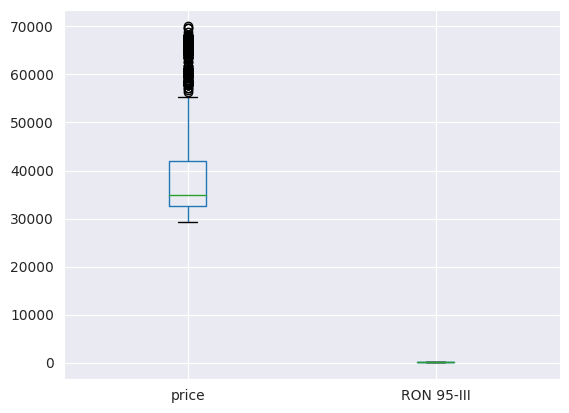

In [7]:
df.boxplot()

In [8]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df.at[df.index[0], 'price'] = min(max(df.iloc[0]['price'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df.index[previous_date_index]
        previous_value = df.loc[previous_date, 'price']
        df.at[index, 'price'] = previous_value

Số lượng outlier: 230


<Axes: >

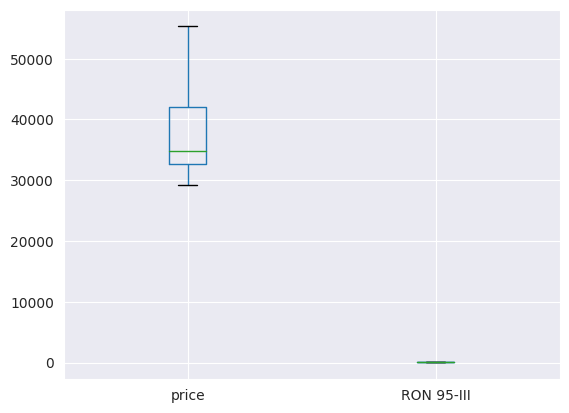

In [9]:
df.boxplot()

In [10]:
df = df.dropna()

In [11]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,RON 95-III
price,1.000000,0.606977
RON 95-III,0.606977,1.000000


In [12]:
fillter_feature = ['price', 'RON 95-III']
df = df[fillter_feature]

In [13]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,RON 95-III
price,1.000000,0.606977
RON 95-III,0.606977,1.000000


<Axes: xlabel='date'>

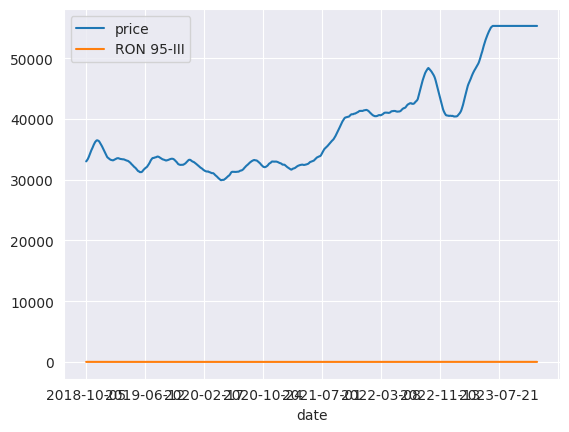

In [14]:
df = df.rolling(45).mean()
df = df.dropna()
df.plot()

In [15]:
nobs = int(len(df) * 0.7)
df_train, df_test = df[0:nobs], df[nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(1339, 2)
(575, 2)


In [16]:
from google.colab import files


## Kiểm tra stationary

In [17]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [18]:
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.663
 No. Lags Chosen       = 3
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.8561. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "RON 95-III" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.208
 No. Lags Chosen       = 17
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.9376. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




In [19]:
df_differenced = df_train.diff().dropna()

In [20]:
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.2671
 No. Lags Chosen       = 2
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0005. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "RON 95-III" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.245
 No. Lags Chosen       = 16
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0006. Rejecting Null Hypothesis.
 => Series is Stationary.




## Train model

In [21]:
model = VAR(df_differenced)
for i in range(1, 50):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -5.895951683125897
BIC :  -5.872624008135164
FPE :  0.002750557479410327
HQIC:  -5.887211260867985 

Lag Order = 2
AIC :  -5.899188654320375
BIC :  -5.8602856950831255
FPE :  0.0027416685490170433
HQIC:  -5.884611936330143 

Lag Order = 3
AIC :  -5.894382416294404
BIC :  -5.839885328660185
FPE :  0.0027548777146055065
HQIC:  -5.873961906777637 

Lag Order = 4
AIC :  -5.890440772985606
BIC :  -5.82033067547694
FPE :  0.0027657584895458545
HQIC:  -5.864168960889865 

Lag Order = 5
AIC :  -5.885675403937522
BIC :  -5.799933377648
FPE :  0.0027789707471887644
HQIC:  -5.8535447629098005 

Lag Order = 6
AIC :  -5.88363949370585
BIC :  -5.782246582197886
FPE :  0.002784635610754685
HQIC:  -5.845642482050097 

Lag Order = 7
AIC :  -5.8814570477551475
BIC :  -5.764394256957361
FPE :  0.002790721430956649
HQIC:  -5.837586108389627 

Lag Order = 8
AIC :  -5.877332861749807
BIC :  -5.744581159854064
FPE :  0.0028022571064576372
HQIC:  -5.827580422164315 

Lag Order = 9
AIC :  

In [22]:
x = model.select_order(maxlags=50)
x.summary()

,AIC,BIC,FPE,HQIC
0,0.2135,0.2215,1.238,0.2165
1,-5.914,-5.889*,0.002703,-5.905
2,-5.916,-5.876,0.002695,-5.901
3,-5.912,-5.856,0.002706,-5.891
4,-5.910,-5.838,0.002712,-5.883
5,-5.906,-5.818,0.002722,-5.873
6,-5.907,-5.803,0.002721,-5.868
7,-5.905,-5.785,0.002726,-5.860
8,-5.903,-5.767,0.002731,-5.852
9,-5.899,-5.746,0.002743,-5.842


In [23]:
model_fitted = model.fit(47)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Jun, 2024
Time:                     04:55:28
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -5.68941
Nobs:                     1291.00    HQIC:                  -6.16408
Log likelihood:           689.317    FPE:                 0.00158249
AIC:                     -6.44929    Det(Omega_mle):      0.00137299
--------------------------------------------------------------------
Results for equation price
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.171419         0.234356            0.731           0.465
L1.price               0.890953         0.028898           30.831           0.000
L1.RON 95-III         35.355629        50.814552        

In [24]:
def adjust(val, length= 6): return str(val).ljust(length)

In [25]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(adjust(col), ':', round(val, 2))

price  : 2.0
RON 95-III : 2.0


In [26]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

47


array([[ 2.88888889e+01,  1.06666667e-02],
       [ 2.88888889e+01,  1.06666667e-02],
       [ 2.66666667e+01,  2.57777778e-02],
       [ 3.55555556e+01,  2.57777778e-02],
       [ 1.33333333e+01,  2.57777778e-02],
       [ 8.88888889e+00,  2.57777778e-02],
       [ 1.55555556e+01,  2.57777778e-02],
       [-2.22222222e+00,  2.57777778e-02],
       [-6.66666667e+00,  2.57777778e-02],
       [-1.11111111e+01,  2.57777778e-02],
       [ 8.88888889e+00,  2.57777778e-02],
       [ 2.88888889e+01,  2.57777778e-02],
       [ 6.66666667e+00,  2.57777778e-02],
       [ 8.88888889e+00,  2.57777778e-02],
       [-4.44444444e+00,  2.57777778e-02],
       [ 0.00000000e+00,  3.55555556e-02],
       [ 8.88888889e+00,  3.55555556e-02],
       [ 4.44444444e+00,  3.55555556e-02],
       [-1.77777778e+01,  3.55555556e-02],
       [-2.22222222e+00,  3.55555556e-02],
       [-4.44444444e+00,  3.55555556e-02],
       [-2.66666667e+01,  3.55555556e-02],
       [-2.66666667e+01,  3.55555556e-02],
       [-2.

In [27]:
import joblib
joblib.dump(model_fitted, 'var_gia_lua.joblib')

['var_gia_lua.joblib']

In [28]:
from google.colab import files
files.download('var_gia_lua.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
# Forecast
nobs = len(df_test)
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,price_2d,RON 95-III_2d
date,,
2022-06-05,43.937181,0.018699
2022-06-06,41.084031,0.017402
2022-06-07,50.445962,0.014529
2022-06-08,51.910903,0.018785
2022-06-09,46.262656,0.019636
...,...,...
2023-12-27,6.658552,0.009249
2023-12-28,6.655365,0.009266
2023-12-29,6.645903,0.009268


In [30]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+ '_2d'].cumsum()
    return df_fc

In [31]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)
df_results.loc[:, ['price_forecast']]

,price_forecast
date,
2022-06-05,41521.714959
2022-06-06,41562.798990
2022-06-07,41613.244951
2022-06-08,41665.155854
2022-06-09,41711.418510
...,...
2023-12-27,47157.755943
2023-12-28,47164.411308
2023-12-29,47171.057211


### Đánh giá mô hình VAR

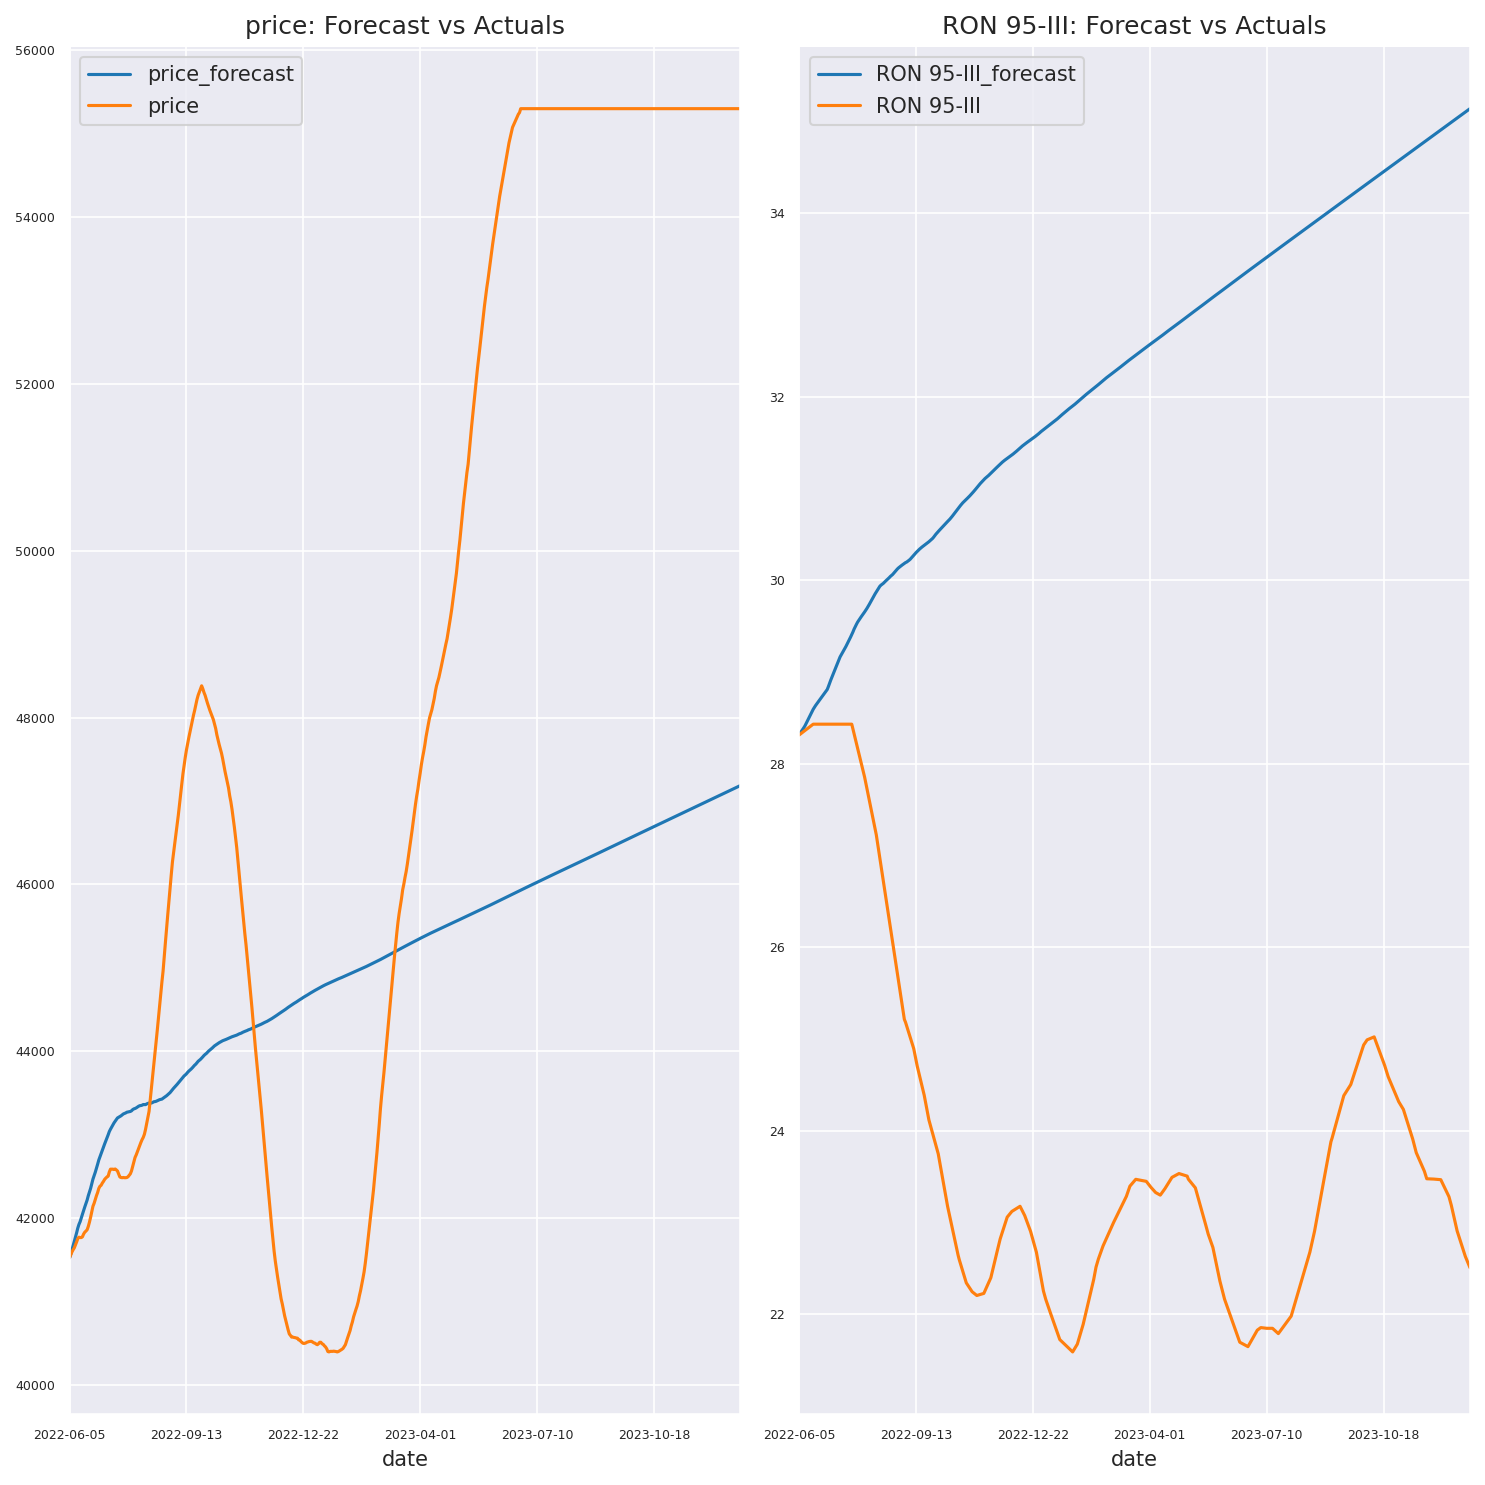

In [32]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [33]:
from sklearn.metrics import mean_absolute_percentage_error

def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(actual, forecast) * 100  # MAPE     # ME
    rmse = np.mean((forecast - actual)**2)**.5  # RMS
    return({'mape':mape, 'rmse':rmse})

In [34]:
print('Forecast Accuracy of: rgnp')
accuracy_prod = forecast_accuracy(df_results['price_forecast'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: rgnp
mape   :  9.5713
rmse   :  5914.7879


In [35]:
import joblib
joblib.dump(model_fitted, var_file_name)
from google.colab import files
files.download(var_file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## VARMA Model

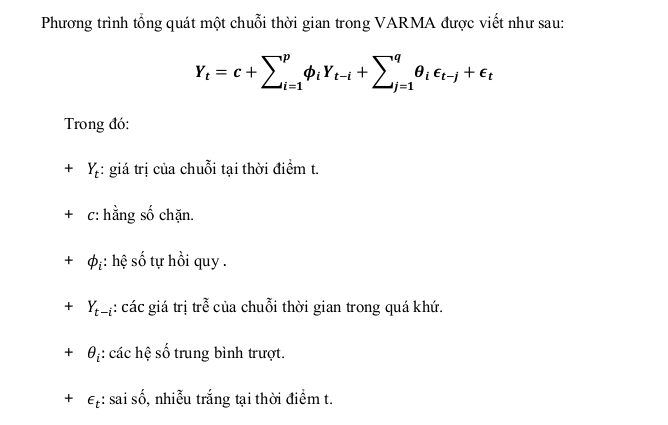

Mô hình Vector Autoregressive Moving Average (VARMA) là sự kết hợp của mô hình VAR và mô hình VMA, giúp trong việc mô hình hóa chuỗi thời gian đa biến bằng cách xem xét cả thứ tự của lag và thứ tự của trung bình di chuyển (p và q) trong mô hình.

In [36]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.0 MB/s eta 0:00:00


In [37]:
from pmdarima import auto_arima

In [38]:
columns_train = fillter_feature

In [39]:
pq = []
for name, column in df_differenced[columns_train].items():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(df_differenced[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : price
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9790.716, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9803.422, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9793.780, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9792.387, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9801.422, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9792.583, Time=1.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9792.589, Time=2.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9790.940, Time=1.68 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=9791.631, Time=1.31 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9794.628, Time=2.56 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=9788.716, Time=0.71 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=9790.388, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=9791.781, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=9790.583, Time=0.8

In [40]:
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn import metrics

In [41]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[str(col)+'_forecast'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [42]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE Open','RMSE High','RMSE Low','RMSE Close'])
print('Grid Search Started')
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(df_differenced[columns_train], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 30)
        inv_res = inverse_diff(df_train[columns_train], result)
        Opensrmse = np.sqrt(metrics.mean_squared_error(df_test['price'][:30], inv_res['price_forecast']))

        print(({'p': i[0], 'q': i[2], 'RMSE Open':Opensrmse}))


Grid Search Started
 Running for (1, 1, 1)
{'p': 1, 'q': 1, 'RMSE Open': 110.73956961732199}


In [43]:
# from above example we can see that p=1 , q=2, tr=n gives least RMSE
model = VARMAX(df_differenced[columns_train], order=(3,1),trends = 'n').fit( disp=False)


In [44]:
result = model.forecast(len(df_test))

In [45]:
inv_res = inverse_diff(df_train[columns_train], result)

Đánh giá mô hình

In [46]:
accuracy_prod = forecast_accuracy(inv_res['price_forecast'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

mape   :  9.8423
rmse   :  6189.241


In [47]:
inv_res.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 575 entries, 2022-06-05 to 2023-12-31
Freq: D
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                575 non-null    float64
 1   RON 95-III           575 non-null    float64
 2   price_forecast       575 non-null    float64
 3   RON 95-III_forecast  575 non-null    float64
dtypes: float64(4)
memory usage: 22.5 KB


In [48]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 575 entries, 2022-06-05 to 2023-12-31
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price       575 non-null    float64
 1   RON 95-III  575 non-null    float64
dtypes: float64(2)
memory usage: 13.5+ KB


In [49]:
inv_res.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 575 entries, 2022-06-05 to 2023-12-31
Freq: D
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   price                575 non-null    float64
 1   RON 95-III           575 non-null    float64
 2   price_forecast       575 non-null    float64
 3   RON 95-III_forecast  575 non-null    float64
dtypes: float64(4)
memory usage: 22.5 KB


In [50]:
df_test.index = pd.to_datetime(df_test.index)
df_train.index = pd.to_datetime(df_train.index)


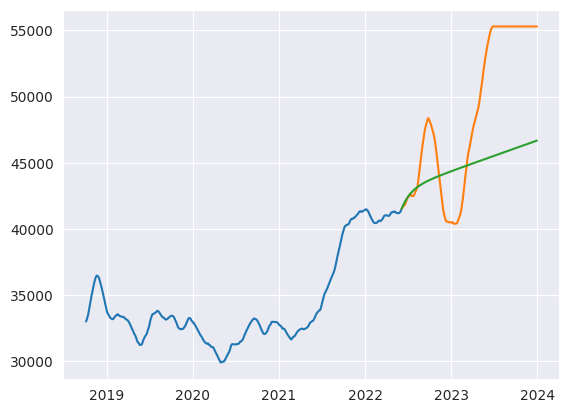

In [51]:
import matplotlib.pyplot as plt

plt.plot(df_train.price)
plt.plot(df_test.price)
plt.plot(inv_res.price_forecast)

plt.show()